In [ ]:
# Import necessary packages
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sn
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer,IterativeImputer
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import plot_partial_dependence as pdp
from sklearn import preprocessing
import statsmodels.api as sm
!pip install scorecardpy
!pip install pygam
import scorecardpy as sc
from pygam import LogisticGAM, s, f
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import roc_auc_score

from scipy.stats import norm

warnings.filterwarnings('ignore')
%matplotlib inline

threshold = 0.5

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 61kB 2.6MB/s 
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.2-cp36-none-any.whl size=57826 sha256=69f6099e7aedd8b58b53bcecee306b5377682824a7de3c949b175d01e7d50540
  Stored in directory: /root/.cache/pip/wheels/1d/66/14/23aeb4e1128278f5880580e2fdd10e956de112a5d56a3a043e
Successfully built scorecardpy
     |████████████████████████████████| 1.8MB 6.3MB/s 


In [ ]:
# Mount your google drive folder please. 
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load the training dataset
# This is the path where I stored the HelocData File.
# Please change the path to where you stored the HelocData file in your Drive after mounting, thank you.
df = pd.read_csv('/content/drive/My Drive/STAT3612/HelocData.csv')
df = df.replace(to_replace =['Bad','Good'], value =[0,1])   # Bad = 0, Good = 1

In [ ]:
# Split data
np.random.seed(50)
df_train,df_test = train_test_split(df, test_size=0.2)

Before modelling, our first step is to understand the distribution of missing values of the training dataset. We plot a bar chart to show the frequency of the missing values of different features.

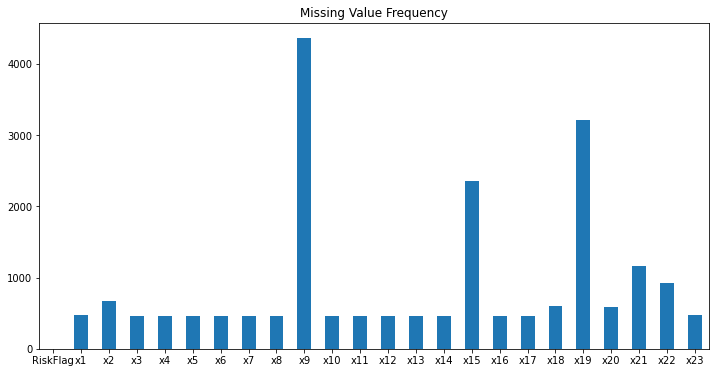

In [ ]:
# Step 1: Exploratory Data Analysis

# (1): Plot a bar chart to understand the missing value frequency of each feature
df_train_copy = df_train.copy()
df_train_copy = df_train_copy.replace(to_replace =[-7,-8,-9], value =[np.nan,np.nan,np.nan])
missing_freq=df_train_copy.isnull().sum()
missing_freq.plot.bar(x='Variable', y='Frequency', rot=0, title='Missing Value Frequency', figsize=(12,6))
plt.show()

As shown in the above barplot, x9, x15 and x19 have an especially high frequency of missing values.

- The number of months since most recent delinquency, represented by x9, can be a missing value when the data is not available, or when no delinquency has occurred.

- The number of months since most recent inquiries excluding last 7  days, denoted by x15, can be a missing value when the data is not available, or when no inquries have ever been made.

- The net fraction installment burden, or x19, has also a high frequency of missing values, but the reason is not yet known at this stage.

We believe that the types of missing values could also be some important hints to the value of RiskFlag, so we further investigate these relationships for creating the following grouped barplots:

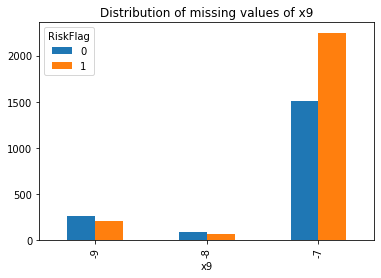

In [ ]:
# Plot the distribution of missing values of x9
df.iloc[df_train_copy[df_train_copy.loc[:,'x9'].isnull()].index,:].groupby('RiskFlag').x9.value_counts().unstack(0).plot.bar(title='Distribution of missing values of x9')
plt.show()

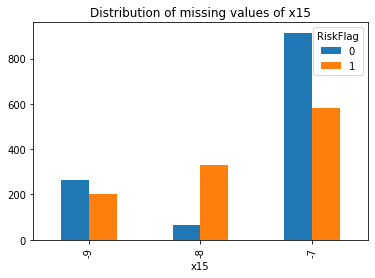

In [ ]:
# Plot the distribution of missing values of x15
df.iloc[df_train_copy[df_train_copy.loc[:,'x15'].isnull()].index,:].groupby('RiskFlag').x15.value_counts().unstack(0).plot.bar(title='Distribution of missing values of x15')
plt.show()

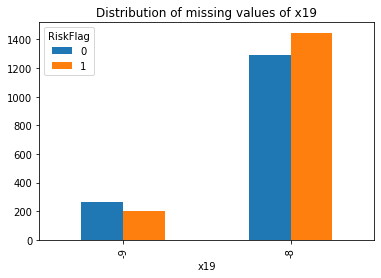

In [ ]:
# Plot the distribution of missing values of x19
df.iloc[df_train_copy[df_train_copy.loc[:,'x19'].isnull()].index,:].groupby('RiskFlag').x19.value_counts().unstack(0).plot.bar(title='Distribution of missing values of x19')
plt.show()

From the 3 barplots above, we conclude that the types of missing values of x9, x15 and x19 have siginificant effects on RiskFlag. Therefore, we would take this into consideration by adding additional features ('x9_neg7', 'x9_neg8', 'x9_neg9', 'x15_neg7', 'x15_neg8', 'x15_neg9', 'x18_neg8', 'x18_neg9') in the next step.

The variables x6 and x7 represents the number of trades that last for 60+ days and 90+ days ever. These two variables are highly correlated since every trade that lasts for 90+days is counted in both x6 and x7.

Similarly, the variables x16 and x17, which denote the number of inquries in the last 6 months including the last 7 days and excluding the last 7 days respectively, are also highly correlated.

To eliminate this problem, we propose the variable 'Numer_Trades_60_To_90', which is the total number of trades that last for more than 60 and not more than 90 days, as well as 'Inq_last_7_days', which is the number of inquiries made in the last 7 days. On the other hand, the variables x6 and x16 will be dropped.

The variables x8 and x9 are slightly more complicated. x8 represents the percentage of trades which never go delinquent, while x9 represents the number of months since the most recent delinquency. From the cell below, we can see that if x8=100, then x9=-7, however, x9=-7 does not necessarily imply x8=100, although this holds almost all cases except a few. In view of this situation, we should handle the imputation of missing values with care. For those cases with x8=100 and x9=-7, we impute x8=0 and x9=0, while add a binary variable called 'NeverDelq' which marks these cases 1 and 0 otherwise. For those cases with x8!=100 and x9=-7, we do the normal imputation. For other missing value cases, normal imputation is done as expected.

In [ ]:
print(df_train.loc[df_train.x8==100,'x9'].value_counts())
print(df_train.loc[df_train.x9==-7,'x8'].value_counts())

-7    3707
Name: x9, dtype: int64
100    3707
97       11
98        8
96        8
94        6
95        4
93        1
91        1
89        1
33        1
90        1
88        1
78        1
Name: x8, dtype: int64


It is known that x10 and x11 are categorical variables. One-hot encoding will thus be employed.

The variables 'x14 * x19' and '(100-x14) * x18' are also added. Here we assume that every trade are either installment trade or revolving trade. Since x14 is the 100 times of percentage of installment trades, (100-x14) is the 100 times of percentage of revolving trades. As x19 and x18 represent the net fraction of installment burden and the net fraction of revolving burden respectively, the weighted sum of the interaction terms 'x14 * x19' and '(100-x14) * x18' can mean the total burden borne by the respondent.

The 'BlackScholes' Variable is a feature that was engineered based on the Black Scholes Pricing Formula. In particular, we have made use of Phi(d2) which has the economical interpretation of the risk neutral probability that a long call written on the underlying asset would expire in the money. We have thus utilized the d2 formula from the Black Scholes model and made appropriate replacements based on the data at hand. This thus gives us the Probability that the HELOC would expire "In the money", meaning that the loan's revolving balance would be greater than the credit balance and hence, delinquent.

The following three features that were engineered ('x5 * x1', 'x4 * x1', 'x8 * x1) are quite reasonable intuitively as this is akin to asking if there should be an interactive effect between the consolidated version of the risk markers and the number of satisfactory trades, average months in file and Percent of trades never delinquent. As is seen later on in the analysis it did turn out that especially 'x5 * x1' proved to be quite a strong explanatory variable.

The Features: ('x22/x4', 'x5/x4') are created in an attempt to get an 'average' for 'x22/x4', the intent is to get the average number of trades with a high utilization ration per month in the file. 'x5/x4' Is the 'Average number of satistfactory trades per month in the file'.

'x18 * x20', 'x19 * x21' Both have the interpreation of a Fraction of Burden multiplied by its respective number of trades with Balance. This is done to extract a measure of not just the burden but also its interaction with the number of trades with balance.

'x10_7.0', 'x11_8.0' dropped

In [ ]:
# Rows with all missing feature values are removed
df_train.drop(df_train[df_train.iloc[:,1:].isnull().all(axis=1)].index, inplace = True)

# Create x_train and y_train
x_train = df_train.iloc[:,1:].copy()
y_train = df_train.iloc[:,0].copy()

# Convert all missing values (-7, -8, -9) to np.nan
x_train = x_train.replace(to_replace =[-7,-8,-9], value =[np.nan,np.nan,np.nan])

# Create feature 'NeverDelq'
x_train.loc[x_train.x8==100, 'NeverDelq'] = 1
x_train.loc[x_train.x8!=100, 'NeverDelq'] = 0

# Prepare for imputation - avoid referencing on rows which has no delinquency record because x8 and x9 now are nonzero iff no delinquency ever
x_train.loc[x_train.NeverDelq==1, 'x8'] = np.nan
x_train.loc[x_train.NeverDelq==1, 'x9'] = np.nan

# Use SimpleImputer for categorical variables, IterativeImputer for numerical variables to impute missing values
I1 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
I2 = IterativeImputer(max_iter=100, min_value=0)
x_train.loc[:,['x10','x11']] = I1.fit_transform(x_train.loc[:,['x10','x11']])
x_train.loc[:,:] = I2.fit_transform(x_train.loc[:,:])   # All x10 and x11 values exist after applying SimpleImputer, 
                                                        # so applying IterativeImputer to all columns is the same as 
                                                        # applying to all except these two columns

# Fill in zero to columns x8 and x9 for rows with NeverDelq = 1
x_train.loc[x_train.NeverDelq==1, 'x8'] = 0
x_train.loc[x_train.NeverDelq==1, 'x9'] = 0

# Create Number_Trades_60_To_90' to avoid multicollinearity caused by x6 and x7, as they stand for Number Trades 60+ Ever and Number Trades 90+ Ever respectively
x_train['Number_Trades_60_To_90']=x_train['x6']-x_train['x7']
x_train.drop(['x6'], axis=1, inplace = True)

# Avoid multicollinearity caused by x16 and x17, as they stand for Number of Inq Last 6 Months and Number of Inq Last 6 Months excl 7 days respectively
x_train['Inq_last_7days']=x_train['x16']-x_train['x17']
x_train.drop(['x16'], axis=1,inplace = True)

# Additional features
x_train['x18*x20'] = x_train['x18']*x_train['x20']
x_train['x19*x21'] = x_train['x19']*x_train['x21']
x_train['x22/x4'] = x_train['x22']/x_train['x4']
x_train['BlackScholes'] = 1-norm.cdf(np.log(x_train['x18'])+(0.0551-0.5*(x_train['x1']/100)*x_train['x4'])/(((x_train['x1']/100)**0.5)*x_train['x4']**0.5))
x_train['x5/x4'] = x_train['x5']/x_train['x4']
x_train['x5*x1'] = x_train['x5']*x_train['x1']
x_train['x4*x1'] = x_train['x4']*x_train['x1']
x_train['x8*x1'] = x_train['x8']*x_train['x1']
x_train['x14*x19'] = x_train['x14']*x_train['x19']
x_train['(100-x14)*x18'] = (100-x_train['x14'])*x_train['x18']
x_train = sm.add_constant(x_train)


In [ ]:
# Rows with all missing feature values are removed

# Create x_train and y_train
#x_train = df_train.iloc[:,1:].copy()
y_train = df_train.iloc[:,0].copy()

In [ ]:
features = ["BlackScholes"]

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1778279410038923, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 60, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
AUC_Train: 0.8335


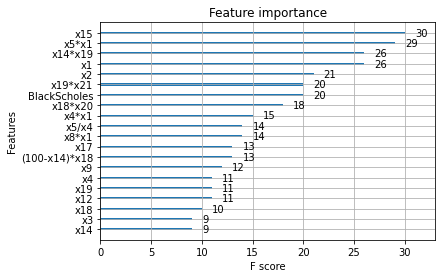

In [ ]:
# Utilizing Xgboost

tuned_parameters = {'learning_rate': np.logspace(-5,1,25), 'max_depth': [2,3,4,5], 'n_estimators': [60,70,80,90,100,110]}

xgb_clf = RandomizedSearchCV(xgb.XGBClassifier(), tuned_parameters, cv=5, n_iter=20, scoring='accuracy', random_state=20190009)
model = xgb_clf.fit(x_train,y_train)
print(model.best_estimator_.get_params())

auc_train = roc_auc_score(y_train,xgb_clf.predict_proba(x_train)[:,1])
print('AUC_Train:',auc_train.round(4))

# Plot the Feature Importance
xgb.plot_importance(xgb_clf.best_estimator_, max_num_features=20) # top 20 most important features
plt.show()

In [ ]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
# define a permutation importance object

perm = PermutationImportance(xgb_clf).fit(x_train, y_train)
# show the importance
eli5.show_weights(perm, feature_names=x_train.columns.values.tolist())

Weight,Feature
0.0442 ± 0.0090,x1
0.0188 ± 0.0038,x15
0.0146 ± 0.0032,x5*x1
0.0081 ± 0.0036,BlackScholes
0.0046 ± 0.0031,x8*x1
0.0033 ± 0.0016,x19*x21
0.0030 ± 0.0017,x14*x19
0.0025 ± 0.0018,x17
0.0023 ± 0.0013,x3
0.0022 ± 0.0019,x8


In [ ]:
# Q4 Test the above 3 models each on the testing data set.
# Step 1 Clean the testing data set in the same manner as was done to the training set

x_test = df_test.iloc[:,1:].copy()
y_test = df_test.iloc[:,0].copy()

x_test = x_test.replace(to_replace =[-7,-8,-9], value =[np.nan,np.nan,np.nan])

# Create feature 'NeverDelq'
x_test.loc[x_test.x8==100, 'NeverDelq'] = 1
x_test.loc[x_test.x8!=100, 'NeverDelq'] = 0

# Prepare for imputation - avoid referencing on rows which has no delinquency record because x8 and x9 now are nonzero iff no delinquency ever
x_test.loc[x_test.NeverDelq==1, 'x8'] = np.nan
x_test.loc[x_test.NeverDelq==1, 'x9'] = np.nan

# SimpleImputer for categorical variables, IterativeImputer for numerical variables
x_test.loc[:,['x10','x11']] = I1.transform(x_test.loc[:,['x10','x11']])
x_test.loc[:,:] = I2.transform(x_test.loc[:,:])

# Avoid multicollinearity caused by x6 and x7, as they stand for Number Trades 60+ Ever and Number Trades 90+ Ever respectively
x_test['Number_Trades_60_To_90']=x_test['x6']-x_test['x7']
x_test.drop(['x6'], axis=1,inplace = True)

# Fill x8 and x9 zero for rows with NeverDelq = 1
x_test.loc[x_test.NeverDelq==1, 'x8'] = 0
x_test.loc[x_test.NeverDelq==1, 'x9'] = 0

# Avoid multicollinearity caused by x16 and x17, as they stand for Number of Inq Last 6 Months and Number of Inq Last 6 Months excl 7 days respectively
x_test['Inq_last_7days']=x_test['x16']-x_test['x17']
x_test.drop(['x16'], axis=1,inplace = True)

# Additional features
x_test['x18*x20'] = x_test['x18']*x_test['x20']
x_test['x19*x21'] = x_test['x19']*x_test['x21']
x_test['x22/x4'] = x_test['x22']/x_test['x4']
x_test['BlackScholes'] = norm.cdf(np.log(x_test['x18'])+(0.0551-0.5*(x_test['x1']/100)*x_test['x4'])/(((x_test['x1']/100)**0.5)*x_test['x4']**0.5))
x_test['x5/x4'] = x_test['x5']/x_test['x4']
x_test['x5*x1'] = x_test['x5']*x_test['x1']
x_test['x4*x1'] = x_test['x4']*x_test['x1']
x_test['x8*x1'] = x_test['x8']*x_test['x1']
x_test['x14*x19'] = x_test['x14']*x_test['x19']
x_test['(100-x14)*x18'] = (100-x_test['x14'])*x_test['x18']
x_test = sm.add_constant(x_test)

x_test

,const,x1,x2,x3,x4,x5,x7,x8,x9,x10,x11,x12,x13,x14,x15,x17,x18,x19,x20,x21,x22,x23,NeverDelq,Number_Trades_60_To_90,Inq_last_7days,x18*x20,x19*x21,x22/x4,BlackScholes,x5/x4,x5*x1,x4*x1,x8*x1,x14*x19,(100-x14)*x18
4012,1.0,80.000000,264.000000,2.000000,87.000000,31.000000,0.0,0.000000,0.000000,7.0,8.0,34.000000,5.000000,9.000000,3.638978,0.000000,8.000000,69.398204,4.000000,1.841291,1.000000,24.000000,1.0,0.0,0.000000,32.000000,127.782313,0.011494,0.018522,0.356322,2480.000000,6960.000000,0.000000,624.583832,728.00000
7370,1.0,86.000000,169.000000,8.000000,141.000000,24.000000,0.0,0.000000,0.000000,7.0,8.0,6.000000,1.000000,8.000000,1.000000,1.000000,9.000000,59.343322,1.000000,1.000000,0.000000,18.000000,1.0,0.0,1.000000,9.000000,59.343322,0.000000,0.000477,0.170213,2064.000000,12126.000000,0.000000,474.746575,828.00000
6326,1.0,56.000000,243.000000,4.000000,42.000000,31.000000,0.0,0.000000,0.000000,7.0,8.0,61.000000,5.000000,35.000000,0.000000,4.000000,91.000000,57.000000,10.000000,3.000000,5.000000,93.000000,1.0,0.0,0.000000,910.000000,171.000000,0.119048,0.982019,0.738095,1736.000000,2352.000000,0.000000,1995.000000,5915.00000
1983,1.0,67.000000,59.000000,3.000000,36.000000,8.000000,1.0,89.000000,7.000000,3.0,4.0,9.000000,2.000000,56.000000,3.000000,1.000000,4.000000,77.000000,2.000000,3.000000,0.000000,83.000000,0.0,0.0,0.000000,8.000000,231.000000,0.000000,0.145007,0.222222,536.000000,2412.000000,5963.000000,4312.000000,176.00000
7859,1.0,73.000000,324.000000,15.000000,89.000000,19.000000,0.0,89.000000,9.000000,4.0,6.0,19.000000,0.000000,21.000000,0.000000,0.000000,34.000000,36.000000,6.000000,3.000000,1.000000,64.000000,0.0,0.0,0.000000,204.000000,108.000000,0.011236,0.309594,0.213483,1387.000000,6497.000000,6497.000000,756.000000,2686.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4090,1.0,57.000000,236.000000,20.000000,97.000000,13.000000,3.0,69.000000,37.000000,0.0,2.0,16.000000,0.000000,38.000000,19.000000,0.000000,101.000000,57.714445,3.000000,1.000000,2.000000,100.000000,0.0,1.0,0.000000,303.000000,57.714445,0.020619,0.817179,0.134021,741.000000,5529.000000,3933.000000,2193.148912,6262.00000
5785,1.0,71.906077,190.669354,8.442304,72.918005,23.055427,0.0,92.676782,33.786134,7.0,8.0,23.698247,2.076785,35.981372,2.447583,1.400359,39.994525,67.505504,4.511762,2.552234,1.317045,68.071501,0.0,0.0,0.050157,180.445798,172.289854,0.018062,0.530226,0.316183,1657.825315,5243.247699,6664.023814,2428.940629,2560.39465
4403,1.0,67.000000,181.000000,6.000000,62.000000,27.000000,0.0,96.000000,26.000000,6.0,6.0,27.000000,4.000000,26.000000,0.000000,2.000000,34.000000,71.962820,3.000000,1.000000,2.000000,33.000000,0.0,0.0,0.000000,102.000000,71.962820,0.032258,0.622606,0.435484,1809.000000,4154.000000,6432.000000,1871.033311,2516.00000
5061,1.0,59.000000,162.000000,33.000000,74.000000,11.000000,2.0,71.000000,9.000000,4.0,3.0,14.000000,0.000000,43.000000,2.867130,0.000000,83.000000,17.000000,4.000000,3.000000,1.000000,100.000000,0.0,0.0,0.000000,332.000000,51.000000,0.013514,0.869365,0.148649,649.000000,4366.000000,4189.000000,731.000000,4731.00000


In [ ]:
#x_test = df_test.iloc[:,1:].copy()
y_test = df_test.iloc[:,0].copy()

In [ ]:
x_train

,const,x1,x2,x3,x4,x5,x7,x8,x9,x10,x11,x12,x13,x14,x15,x17,x18,x19,x20,x21,x22,x23,NeverDelq,Number_Trades_60_To_90,Inq_last_7days,x18*x20,x19*x21,x22/x4,BlackScholes,x5/x4,x5*x1,x4*x1,x8*x1,x14*x19,(100-x14)*x18
354,1.0,87.0,99.000000,37.0,99.0,24.0,0.0,0.0,0.0,7.0,8.0,3.0,0.0,29.0,15.000000,0.0,11.0,8.000000,1.0,2.0,0.0,38.0,1.0,0.0,0.0,11.0,16.000000,0.000000,0.987340,0.242424,2088.0,8613.0,0.0,232.000000,781.0
3167,1.0,55.0,137.000000,7.0,67.0,13.0,1.0,79.0,1.0,0.0,2.0,14.0,1.0,21.0,0.000000,8.0,26.0,89.000000,2.0,2.0,0.0,71.0,0.0,0.0,1.0,52.0,178.000000,0.000000,0.408283,0.194030,715.0,3685.0,4345.0,1869.000000,2054.0
2784,1.0,83.0,228.000000,2.0,95.0,46.0,0.0,0.0,0.0,7.0,8.0,51.0,3.0,33.0,1.000000,1.0,26.0,100.000000,2.0,1.0,1.0,27.0,1.0,0.0,0.0,52.0,100.000000,0.010526,0.880118,0.484211,3818.0,7885.0,0.0,3300.000000,1742.0
1010,1.0,50.0,211.000000,15.0,98.0,15.0,1.0,48.0,2.0,4.0,5.0,21.0,0.0,19.0,1.456281,1.0,23.0,23.000000,2.0,2.0,0.0,31.0,0.0,2.0,0.0,46.0,46.000000,0.000000,0.639317,0.153061,750.0,4900.0,2400.0,437.000000,1863.0
2157,1.0,65.0,115.000000,9.0,49.0,18.0,1.0,0.0,0.0,7.0,8.0,21.0,1.0,30.0,0.000000,1.0,56.0,81.000000,7.0,2.0,3.0,82.0,1.0,0.0,0.0,392.0,162.000000,0.061224,0.112503,0.367347,1170.0,3185.0,0.0,2430.000000,3920.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8324,1.0,65.0,186.000000,3.0,40.0,15.0,1.0,0.0,0.0,6.0,8.0,15.0,4.0,20.0,2.000000,4.0,39.0,72.000000,7.0,1.0,0.0,67.0,1.0,0.0,0.0,273.0,72.000000,0.000000,0.130325,0.375000,975.0,2600.0,0.0,1440.000000,3120.0
10206,1.0,73.0,165.000000,3.0,62.0,22.0,2.0,96.0,3.0,0.0,2.0,23.0,5.0,39.0,2.000000,1.0,10.0,55.000000,4.0,5.0,0.0,69.0,0.0,0.0,0.0,40.0,275.000000,0.000000,0.853830,0.354839,1606.0,4526.0,7008.0,2145.000000,610.0
6253,1.0,61.0,183.000000,5.0,68.0,2.0,0.0,67.0,10.0,3.0,5.0,3.0,1.0,33.0,0.696707,2.0,108.0,70.141932,1.0,1.0,1.0,67.0,0.0,1.0,0.0,108.0,70.141932,0.014706,0.070722,0.029412,122.0,4148.0,4087.0,2314.683741,7236.0
10123,1.0,81.0,204.000000,8.0,85.0,40.0,0.0,0.0,0.0,7.0,8.0,43.0,1.0,35.0,0.000000,3.0,9.0,85.000000,5.0,2.0,0.0,54.0,1.0,0.0,0.0,45.0,170.000000,0.000000,0.974108,0.470588,3240.0,6885.0,0.0,2975.000000,585.0


In [ ]:
#Utilizing Xgboost for the test data
#x_train.columns[:]
#a = xgb_clf.predict_proba(x_test)
#a
x_test.loc[:,"BlackScholes"]
#auc_test = roc_auc_score(y_test,xgb_clf.predict_proba(x_test.loc[:,"BlackScholes"])[:,1])
#print('AUC_Test:',auc_test.round(4))
# Plot the Feature Importance
#xgb.plot_importance(xgb_clf.predict_proba(x_test.loc[:,x_train.columns]))
#plt.show()

4012    0.018522
7370    0.000477
6326    0.982019
1983    0.145007
7859    0.309594
          ...   
4090    0.817179
5785    0.530226
4403    0.622606
5061    0.869365
5663    0.066204
Name: BlackScholes, Length: 2092, dtype: float64

In [ ]:
print(x_train.columns)

Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21',
       'x22', 'x23'],
      dtype='object')


In [ ]:
y_train

354      1
3167     0
2784     1
1010     0
2157     0
        ..
8324     1
10206    1
6253     0
10123    0
5600     1
Name: RiskFlag, Length: 8367, dtype: int64

In [ ]:
x_train

,const,x1,x2,x3,x4,x5,x7,x8,x9,x10,x11,x12,x13,x14,x15,x17,x18,x19,x20,x21,x22,x23,NeverDelq,Number_Trades_60_To_90,Inq_last_7days,x18*x20,x19*x21,x22/x4,BlackScholes,x5/x4,x5*x1,x4*x1,x8*x1,x14*x19,(100-x14)*x18
354,1.0,87.0,99.000000,37.0,99.0,24.0,0.0,0.0,0.0,7.0,8.0,3.0,0.0,29.0,15.000000,0.0,11.0,8.000000,1.0,2.0,0.0,38.0,1.0,0.0,0.0,11.0,16.000000,0.000000,0.987340,0.242424,2088.0,8613.0,0.0,232.000000,781.0
3167,1.0,55.0,137.000000,7.0,67.0,13.0,1.0,79.0,1.0,0.0,2.0,14.0,1.0,21.0,0.000000,8.0,26.0,89.000000,2.0,2.0,0.0,71.0,0.0,0.0,1.0,52.0,178.000000,0.000000,0.408283,0.194030,715.0,3685.0,4345.0,1869.000000,2054.0
2784,1.0,83.0,228.000000,2.0,95.0,46.0,0.0,0.0,0.0,7.0,8.0,51.0,3.0,33.0,1.000000,1.0,26.0,100.000000,2.0,1.0,1.0,27.0,1.0,0.0,0.0,52.0,100.000000,0.010526,0.880118,0.484211,3818.0,7885.0,0.0,3300.000000,1742.0
1010,1.0,50.0,211.000000,15.0,98.0,15.0,1.0,48.0,2.0,4.0,5.0,21.0,0.0,19.0,1.456281,1.0,23.0,23.000000,2.0,2.0,0.0,31.0,0.0,2.0,0.0,46.0,46.000000,0.000000,0.639317,0.153061,750.0,4900.0,2400.0,437.000000,1863.0
2157,1.0,65.0,115.000000,9.0,49.0,18.0,1.0,0.0,0.0,7.0,8.0,21.0,1.0,30.0,0.000000,1.0,56.0,81.000000,7.0,2.0,3.0,82.0,1.0,0.0,0.0,392.0,162.000000,0.061224,0.112503,0.367347,1170.0,3185.0,0.0,2430.000000,3920.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8324,1.0,65.0,186.000000,3.0,40.0,15.0,1.0,0.0,0.0,6.0,8.0,15.0,4.0,20.0,2.000000,4.0,39.0,72.000000,7.0,1.0,0.0,67.0,1.0,0.0,0.0,273.0,72.000000,0.000000,0.130325,0.375000,975.0,2600.0,0.0,1440.000000,3120.0
10206,1.0,73.0,165.000000,3.0,62.0,22.0,2.0,96.0,3.0,0.0,2.0,23.0,5.0,39.0,2.000000,1.0,10.0,55.000000,4.0,5.0,0.0,69.0,0.0,0.0,0.0,40.0,275.000000,0.000000,0.853830,0.354839,1606.0,4526.0,7008.0,2145.000000,610.0
6253,1.0,61.0,183.000000,5.0,68.0,2.0,0.0,67.0,10.0,3.0,5.0,3.0,1.0,33.0,0.696707,2.0,108.0,70.141932,1.0,1.0,1.0,67.0,0.0,1.0,0.0,108.0,70.141932,0.014706,0.070722,0.029412,122.0,4148.0,4087.0,2314.683741,7236.0
10123,1.0,81.0,204.000000,8.0,85.0,40.0,0.0,0.0,0.0,7.0,8.0,43.0,1.0,35.0,0.000000,3.0,9.0,85.000000,5.0,2.0,0.0,54.0,1.0,0.0,0.0,45.0,170.000000,0.000000,0.974108,0.470588,3240.0,6885.0,0.0,2975.000000,585.0


In [ ]:
# Fit the Xgboost model

features = ["x1","x15","x5*x1","BlackScholes","x4*x1"]
b = x_train.loc[:,features]
b
#b = x_train.loc[:,"BlackScholes"]
Xgb_Clf_2 = xgb.XGBClassifier()
Xgb_Clf_2.fit(b,y_train)


auc_train = roc_auc_score(y_train,Xgb_Clf.predict_proba(b)[:,1])
print('AUC on training data using Xgboost:',auc_train)

AUC on training data using Xgboost: 0.8144140274038646


In [ ]:
# Xgboost model accuracy on testing data
auc_test = roc_auc_score(y_test,Xgb_Clf_2.predict_proba(x_test.loc[:,features])[:,1])
print('Accuracy on testing data using Xgboost:',auc_test)

Accuracy on testing data using Xgboost: 0.7510753528665868


In [ ]:
# Prepare x_train_bin with penalized B-spline features with degrees up to 3
gam = LogisticGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) +
                  s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22), fit_intercept=True)

# Model fitting, Print model summary
gam.gridsearch(x_train.values, y_train.values)
print(gam.summary())

100% (11 of 11) |########################| Elapsed Time: 0:00:54 Time:  0:00:54


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     98.7421
Link Function:                        LogitLink Log Likelihood:                                 -4464.2482
Number of Samples:                         8367 AIC:                                             9125.9807
                                                AICc:                                            9128.4119
                                                UBRE:                                               3.1002
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2295
Feature Function                  Lam

In [ ]:
# Function of plotting confusion matrix of the test result and printing prediction accuracy on test set

def AccuracyReport(y_test, y_pred):
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    sn.heatmap(cnf_matrix,annot=True,cmap='Blues')
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.show()

    accuracy_test = accuracy_score(y_test, y_pred)
    print('Prediction accuracy on the test set =', np.round(accuracy_test,4))

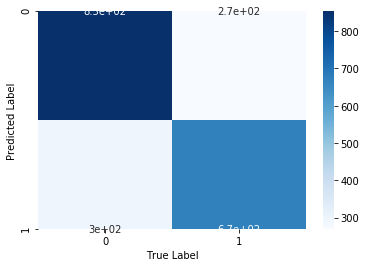

Prediction accuracy on the test set = 0.729


In [ ]:
# Part (4): Testing of GAM with the penalized B-splines with degrees up to 3 in (3)

# Prepare x_test_pbs
# Generate prediction of y_test by fitted logistic model
y_pred_test_pbs = (gam.predict(x_test.values) > threshold).astype(int)

AccuracyReport(y_test, y_pred_test_pbs)